In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from torchmodel import UNet
from root_dataset import Train_dataset, Test_dataset
import albumentations as albu
import segmentation_models_pytorch as smp
import random
import numpy as np
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

c:\Users\neden\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
height = 512

In [4]:
def get_train_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        albu.GridDistortion(p=0.5),
        albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.RandomGamma(p=0.5),
        albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
        albu.GaussNoise(),
        albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
        #albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [5]:
def get_val_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        # albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [6]:
train_aug = get_train_augmentation(height)
val_aug = get_val_augmentation(height)

In [7]:
train = Train_dataset(height,train_aug,'crosval/train','castom-masks/masks_machine',device)
val = Train_dataset(height,val_aug,'crosval/val','castom-masks/masks_machine',device)

['AAE_0014.png', 'AAE_0016.png', 'AAE_0017.png', 'AAE_0019.png', 'AAE_0021.png', 'AAE_0022.png', 'AAE_0025.png', 'AAE_0027.png', 'AAE_0028.png', 'AAE_0036.png', 'AAE_0037.png', 'AAE_0040.png', 'AAE_0041.png', 'AAE_0045.png', 'AAE_0047.png', 'AAE_0048.png', 'AAE_0057.png', 'AAE_0058.png', 'AAE_0062.png', 'AAE_0063.png', 'AAE_0068.png', 'AAE_0070.png', 'AAE_0071.png', 'AAE_0073.png', 'AAE_0076.png', 'AAE_0080.png', 'AAE_0083.png', 'AAE_0085.png', 'AAE_0087.png', 'AAE_0089.png', 'AAE_0097.png', 'AAE_0098.png', 'AAE_0100.png', 'AAE_0101.png', 'AAE_0107.png', 'AAE_0114.png', 'AAE_0116.png', 'AAE_0117.png', 'AAE_0119.png', 'AAE_0124.png', 'AAE_0125.png', 'AAE_0127.png', 'AAE_0136.png', 'AAE_0140.png', 'AAE_0144.png', 'AAE_0145.png', 'AAE_0146.png', 'AAE_0147.png', 'AAE_0150.png', 'AAE_0154.png', 'AAE_0156.png', 'AAE_0158.png', 'AAE_0161.png', 'AAE_0165.png', 'AAE_0167.png', 'AAE_0170.png', 'AAE_0173.png', 'AAE_0174.png', 'AAE_0176.png', 'AAE_0177.png', 'AAE_0179.png', 'AAE_0180.png', 'AAE_01

<Figure size 640x480 with 0 Axes>

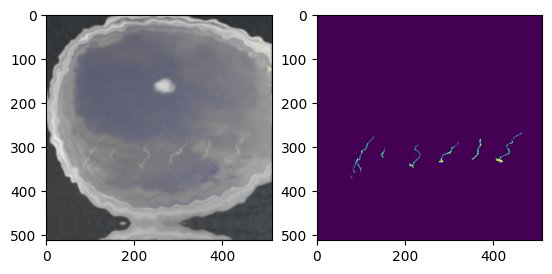

In [8]:
plt.figure()
f, axarr = plt.subplots(1,2) 
image,mask = train.__getitem__(0)
axarr[0].imshow(image.permute(1,2,0).cpu())
axarr[1].imshow(mask.permute(1,2,0).cpu())

In [9]:
model = UNet(3,1)

In [10]:
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False)

In [11]:
focal_loss = smp.losses.FocalLoss('binary')
iou_loss = smp.losses.JaccardLoss('binary')
dice_loss = smp.losses.DiceLoss('binary')
bce_loss = smp.losses.SoftBCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),0.001,amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,verbose=True)

In [12]:
def loss_f(outputs, targets):
    return focal_loss(outputs, targets) * 0.2 + iou_loss(outputs, targets) * 0.2 + dice_loss(outputs, targets) * 0.4 + bce_loss(outputs,targets) * 0.2

In [13]:
def metric(outputs, targets):
    return 1 - dice_loss(outputs, targets)

In [14]:
epochs = 200
patience = 20
model_path = 'models/best-model2.pt'

In [15]:
model.to(device)
best_loss = 100
counter = 0
for epoch in range(epochs):
    train_loss = 0.0
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_f(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss = 0.0

    model.eval()
    for inputs, targets in tqdm(val_loader):
        model.eval()
        outputs = model(inputs)
            
            # Calculate loss
        loss = loss_f(outputs, targets)
        val_loss += loss.item()

    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    improve = False

    if val_loss < best_loss: 
        best_loss = val_loss
        improve = True
        print('model saved')
        torch.save(model,model_path)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Dice: {metric(outputs, targets):.4f} | Val Dice: {metric(outputs, targets):.4f}")

    if not improve:
        counter += 1
        if counter > patience:
            print('early stop')
            break
    else:
        counter = 0
        

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [1/200] | Train Loss: 0.8454 | Val Loss: 0.8449 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [2/200] | Train Loss: 0.8252 | Val Loss: 0.8245 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [3/200] | Train Loss: 0.8166 | Val Loss: 0.8145 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [4/200] | Train Loss: 0.8090 | Val Loss: 0.8093 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [5/200] | Train Loss: 0.8026 | Val Loss: 0.8076 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [6/200] | Train Loss: 0.7994 | Val Loss: 0.7984 | Train Dice: 0.0333 | Val Dice: 0.0333


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [7/200] | Train Loss: 0.7935 | Val Loss: 0.7903 | Train Dice: 0.0333 | Val Dice: 0.0333


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [8/200] | Train Loss: 0.7902 | Val Loss: 0.7866 | Train Dice: 0.0334 | Val Dice: 0.0334


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [9/200] | Train Loss: 0.7876 | Val Loss: 0.7842 | Train Dice: 0.0334 | Val Dice: 0.0334


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [10/200] | Train Loss: 0.7837 | Val Loss: 0.7817 | Train Dice: 0.0334 | Val Dice: 0.0334


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [11/200] | Train Loss: 0.7819 | Val Loss: 0.7809 | Train Dice: 0.0334 | Val Dice: 0.0334


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [12/200] | Train Loss: 0.7799 | Val Loss: 0.7785 | Train Dice: 0.0334 | Val Dice: 0.0334


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [13/200] | Train Loss: 0.7786 | Val Loss: 0.7772 | Train Dice: 0.0333 | Val Dice: 0.0333


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [14/200] | Train Loss: 0.7766 | Val Loss: 0.7753 | Train Dice: 0.0333 | Val Dice: 0.0333


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [15/200] | Train Loss: 0.7755 | Val Loss: 0.7742 | Train Dice: 0.0332 | Val Dice: 0.0332


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [16/200] | Train Loss: 0.7742 | Val Loss: 0.7727 | Train Dice: 0.0332 | Val Dice: 0.0332


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


Epoch [17/200] | Train Loss: 0.7735 | Val Loss: 0.7728 | Train Dice: 0.0331 | Val Dice: 0.0331


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [18/200] | Train Loss: 0.7724 | Val Loss: 0.7716 | Train Dice: 0.0332 | Val Dice: 0.0332


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [19/200] | Train Loss: 0.7721 | Val Loss: 0.7706 | Train Dice: 0.0332 | Val Dice: 0.0332


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [20/200] | Train Loss: 0.7712 | Val Loss: 0.7694 | Train Dice: 0.0331 | Val Dice: 0.0331


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [21/200] | Train Loss: 0.7706 | Val Loss: 0.7689 | Train Dice: 0.0331 | Val Dice: 0.0331


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [22/200] | Train Loss: 0.7697 | Val Loss: 0.7684 | Train Dice: 0.0331 | Val Dice: 0.0331


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [23/200] | Train Loss: 0.7699 | Val Loss: 0.7681 | Train Dice: 0.0331 | Val Dice: 0.0331


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [24/200] | Train Loss: 0.7690 | Val Loss: 0.7676 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [25/200] | Train Loss: 0.7688 | Val Loss: 0.7673 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [26/200] | Train Loss: 0.7687 | Val Loss: 0.7670 | Train Dice: 0.0331 | Val Dice: 0.0331


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [27/200] | Train Loss: 0.7681 | Val Loss: 0.7665 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [28/200] | Train Loss: 0.7677 | Val Loss: 0.7661 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [29/200] | Train Loss: 0.7676 | Val Loss: 0.7661 | Train Dice: 0.0331 | Val Dice: 0.0331


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [30/200] | Train Loss: 0.7675 | Val Loss: 0.7658 | Train Dice: 0.0331 | Val Dice: 0.0331


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [31/200] | Train Loss: 0.7674 | Val Loss: 0.7657 | Train Dice: 0.0332 | Val Dice: 0.0332


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [32/200] | Train Loss: 0.7673 | Val Loss: 0.7653 | Train Dice: 0.0332 | Val Dice: 0.0332


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [33/200] | Train Loss: 0.7670 | Val Loss: 0.7651 | Train Dice: 0.0336 | Val Dice: 0.0336


100%|██████████| 7/7 [00:06<00:00,  1.10it/s]


Epoch [34/200] | Train Loss: 0.7670 | Val Loss: 0.7652 | Train Dice: 0.0332 | Val Dice: 0.0332


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [35/200] | Train Loss: 0.7670 | Val Loss: 0.7651 | Train Dice: 0.0338 | Val Dice: 0.0338


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [36/200] | Train Loss: 0.7668 | Val Loss: 0.7648 | Train Dice: 0.0341 | Val Dice: 0.0341


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [37/200] | Train Loss: 0.7667 | Val Loss: 0.7645 | Train Dice: 0.0345 | Val Dice: 0.0345


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [38/200] | Train Loss: 0.7663 | Val Loss: 0.7644 | Train Dice: 0.0349 | Val Dice: 0.0349


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [39/200] | Train Loss: 0.7662 | Val Loss: 0.7643 | Train Dice: 0.0352 | Val Dice: 0.0352


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [40/200] | Train Loss: 0.7662 | Val Loss: 0.7649 | Train Dice: 0.0340 | Val Dice: 0.0340


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [41/200] | Train Loss: 0.7662 | Val Loss: 0.7647 | Train Dice: 0.0346 | Val Dice: 0.0346


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [42/200] | Train Loss: 0.7660 | Val Loss: 0.7646 | Train Dice: 0.0352 | Val Dice: 0.0352


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [43/200] | Train Loss: 0.7661 | Val Loss: 0.7641 | Train Dice: 0.0350 | Val Dice: 0.0350


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [44/200] | Train Loss: 0.7662 | Val Loss: 0.7639 | Train Dice: 0.0356 | Val Dice: 0.0356


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [45/200] | Train Loss: 0.7657 | Val Loss: 0.7636 | Train Dice: 0.0368 | Val Dice: 0.0368


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [46/200] | Train Loss: 0.7657 | Val Loss: 0.7635 | Train Dice: 0.0368 | Val Dice: 0.0368


100%|██████████| 7/7 [00:06<00:00,  1.10it/s]


model saved
Epoch [47/200] | Train Loss: 0.7657 | Val Loss: 0.7635 | Train Dice: 0.0377 | Val Dice: 0.0377


100%|██████████| 7/7 [00:06<00:00,  1.10it/s]


model saved
Epoch [48/200] | Train Loss: 0.7653 | Val Loss: 0.7633 | Train Dice: 0.0362 | Val Dice: 0.0362


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [49/200] | Train Loss: 0.7653 | Val Loss: 0.7630 | Train Dice: 0.0379 | Val Dice: 0.0379


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [50/200] | Train Loss: 0.7650 | Val Loss: 0.7629 | Train Dice: 0.0381 | Val Dice: 0.0381


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [51/200] | Train Loss: 0.7650 | Val Loss: 0.7629 | Train Dice: 0.0375 | Val Dice: 0.0375


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [52/200] | Train Loss: 0.7650 | Val Loss: 0.7626 | Train Dice: 0.0393 | Val Dice: 0.0393


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [53/200] | Train Loss: 0.7648 | Val Loss: 0.7624 | Train Dice: 0.0395 | Val Dice: 0.0395


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [54/200] | Train Loss: 0.7647 | Val Loss: 0.7622 | Train Dice: 0.0400 | Val Dice: 0.0400


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [55/200] | Train Loss: 0.7644 | Val Loss: 0.7623 | Train Dice: 0.0403 | Val Dice: 0.0403


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [56/200] | Train Loss: 0.7649 | Val Loss: 0.7621 | Train Dice: 0.0409 | Val Dice: 0.0409


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [57/200] | Train Loss: 0.7645 | Val Loss: 0.7618 | Train Dice: 0.0407 | Val Dice: 0.0407


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [58/200] | Train Loss: 0.7646 | Val Loss: 0.7620 | Train Dice: 0.0404 | Val Dice: 0.0404


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [59/200] | Train Loss: 0.7645 | Val Loss: 0.7619 | Train Dice: 0.0411 | Val Dice: 0.0411


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [60/200] | Train Loss: 0.7645 | Val Loss: 0.7619 | Train Dice: 0.0412 | Val Dice: 0.0412


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [61/200] | Train Loss: 0.7644 | Val Loss: 0.7620 | Train Dice: 0.0402 | Val Dice: 0.0402


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [62/200] | Train Loss: 0.7645 | Val Loss: 0.7617 | Train Dice: 0.0419 | Val Dice: 0.0419


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [63/200] | Train Loss: 0.7644 | Val Loss: 0.7618 | Train Dice: 0.0429 | Val Dice: 0.0429


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [64/200] | Train Loss: 0.7640 | Val Loss: 0.7615 | Train Dice: 0.0414 | Val Dice: 0.0414


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [65/200] | Train Loss: 0.7642 | Val Loss: 0.7616 | Train Dice: 0.0418 | Val Dice: 0.0418


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [66/200] | Train Loss: 0.7640 | Val Loss: 0.7616 | Train Dice: 0.0404 | Val Dice: 0.0404


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [67/200] | Train Loss: 0.7640 | Val Loss: 0.7614 | Train Dice: 0.0422 | Val Dice: 0.0422


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [68/200] | Train Loss: 0.7640 | Val Loss: 0.7617 | Train Dice: 0.0402 | Val Dice: 0.0402


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [69/200] | Train Loss: 0.7643 | Val Loss: 0.7614 | Train Dice: 0.0427 | Val Dice: 0.0427


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [70/200] | Train Loss: 0.7643 | Val Loss: 0.7613 | Train Dice: 0.0423 | Val Dice: 0.0423


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [71/200] | Train Loss: 0.7642 | Val Loss: 0.7612 | Train Dice: 0.0417 | Val Dice: 0.0417


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [72/200] | Train Loss: 0.7637 | Val Loss: 0.7613 | Train Dice: 0.0420 | Val Dice: 0.0420


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [73/200] | Train Loss: 0.7642 | Val Loss: 0.7614 | Train Dice: 0.0420 | Val Dice: 0.0420


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [74/200] | Train Loss: 0.7635 | Val Loss: 0.7611 | Train Dice: 0.0422 | Val Dice: 0.0422


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [75/200] | Train Loss: 0.7638 | Val Loss: 0.7611 | Train Dice: 0.0420 | Val Dice: 0.0420


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [76/200] | Train Loss: 0.7640 | Val Loss: 0.7611 | Train Dice: 0.0418 | Val Dice: 0.0418


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [77/200] | Train Loss: 0.7639 | Val Loss: 0.7611 | Train Dice: 0.0422 | Val Dice: 0.0422


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


Epoch [78/200] | Train Loss: 0.7637 | Val Loss: 0.7611 | Train Dice: 0.0423 | Val Dice: 0.0423


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [79/200] | Train Loss: 0.7636 | Val Loss: 0.7610 | Train Dice: 0.0426 | Val Dice: 0.0426


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch 00080: reducing learning rate of group 0 to 1.0000e-04.
Epoch [80/200] | Train Loss: 0.7636 | Val Loss: 0.7612 | Train Dice: 0.0427 | Val Dice: 0.0427


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


model saved
Epoch [81/200] | Train Loss: 0.7637 | Val Loss: 0.7610 | Train Dice: 0.0428 | Val Dice: 0.0428


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [82/200] | Train Loss: 0.7634 | Val Loss: 0.7609 | Train Dice: 0.0432 | Val Dice: 0.0432


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [83/200] | Train Loss: 0.7634 | Val Loss: 0.7609 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [84/200] | Train Loss: 0.7635 | Val Loss: 0.7609 | Train Dice: 0.0433 | Val Dice: 0.0433


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [85/200] | Train Loss: 0.7633 | Val Loss: 0.7609 | Train Dice: 0.0434 | Val Dice: 0.0434


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [86/200] | Train Loss: 0.7635 | Val Loss: 0.7609 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [87/200] | Train Loss: 0.7636 | Val Loss: 0.7609 | Train Dice: 0.0434 | Val Dice: 0.0434


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [88/200] | Train Loss: 0.7633 | Val Loss: 0.7609 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch [89/200] | Train Loss: 0.7632 | Val Loss: 0.7609 | Train Dice: 0.0436 | Val Dice: 0.0436


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [90/200] | Train Loss: 0.7636 | Val Loss: 0.7608 | Train Dice: 0.0434 | Val Dice: 0.0434


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch 00091: reducing learning rate of group 0 to 1.0000e-05.
Epoch [91/200] | Train Loss: 0.7636 | Val Loss: 0.7608 | Train Dice: 0.0433 | Val Dice: 0.0433


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [92/200] | Train Loss: 0.7635 | Val Loss: 0.7609 | Train Dice: 0.0434 | Val Dice: 0.0434


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [93/200] | Train Loss: 0.7637 | Val Loss: 0.7608 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [94/200] | Train Loss: 0.7634 | Val Loss: 0.7608 | Train Dice: 0.0434 | Val Dice: 0.0434


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [95/200] | Train Loss: 0.7635 | Val Loss: 0.7609 | Train Dice: 0.0434 | Val Dice: 0.0434


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [96/200] | Train Loss: 0.7636 | Val Loss: 0.7608 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


Epoch 00097: reducing learning rate of group 0 to 1.0000e-06.
Epoch [97/200] | Train Loss: 0.7633 | Val Loss: 0.7608 | Train Dice: 0.0434 | Val Dice: 0.0434


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [98/200] | Train Loss: 0.7632 | Val Loss: 0.7608 | Train Dice: 0.0434 | Val Dice: 0.0434


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [99/200] | Train Loss: 0.7635 | Val Loss: 0.7609 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [100/200] | Train Loss: 0.7632 | Val Loss: 0.7609 | Train Dice: 0.0433 | Val Dice: 0.0433


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [101/200] | Train Loss: 0.7637 | Val Loss: 0.7608 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch [102/200] | Train Loss: 0.7635 | Val Loss: 0.7609 | Train Dice: 0.0434 | Val Dice: 0.0434


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


Epoch 00103: reducing learning rate of group 0 to 1.0000e-07.
Epoch [103/200] | Train Loss: 0.7637 | Val Loss: 0.7608 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [104/200] | Train Loss: 0.7636 | Val Loss: 0.7609 | Train Dice: 0.0434 | Val Dice: 0.0434


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch [105/200] | Train Loss: 0.7637 | Val Loss: 0.7609 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [106/200] | Train Loss: 0.7635 | Val Loss: 0.7609 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [107/200] | Train Loss: 0.7634 | Val Loss: 0.7608 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [108/200] | Train Loss: 0.7634 | Val Loss: 0.7609 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch 00109: reducing learning rate of group 0 to 1.0000e-08.
Epoch [109/200] | Train Loss: 0.7633 | Val Loss: 0.7609 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [110/200] | Train Loss: 0.7638 | Val Loss: 0.7609 | Train Dice: 0.0435 | Val Dice: 0.0435


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

Epoch [111/200] | Train Loss: 0.7634 | Val Loss: 0.7609 | Train Dice: 0.0435 | Val Dice: 0.0435
early stop


Epoch [61/100] | Train Loss: 0.8235 | Val Loss: 0.8208

In [16]:
model = torch.load(model_path)

Epoch [10/10] | Train Loss: 4.1113 | Val Loss: 3.9804

In [17]:
test = Test_dataset(val_aug,'crosval/test',device)

['AAE_0023.png', 'AAE_0074.png', 'AAE_0086.png', 'AAE_0138.png', 'AAE_0160.png', 'AAE_0172.png', 'AAE_0205.png', 'AAE_0221.png', 'AAE_0223.png', 'AAE_0237.png']


In [18]:
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [19]:
for inputs in tqdm(test_loader):
    model.eval()
    outputs = model(inputs)

100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


In [20]:
outputs.shape

torch.Size([10, 1, 512, 512])

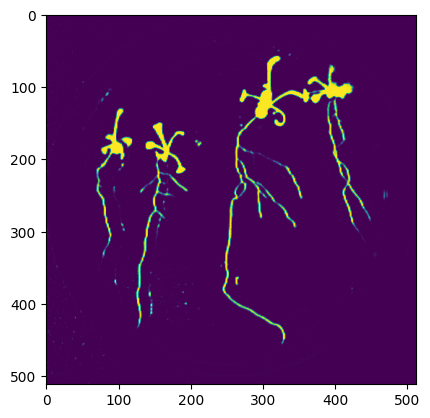

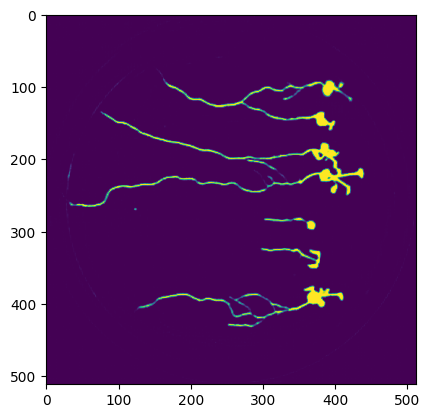

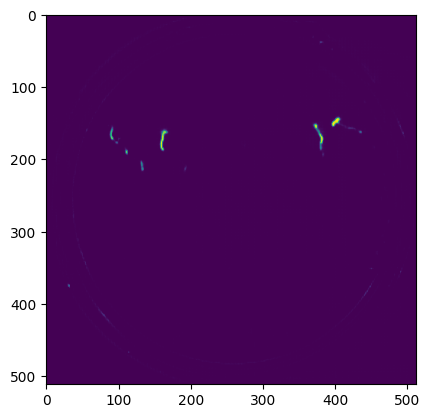

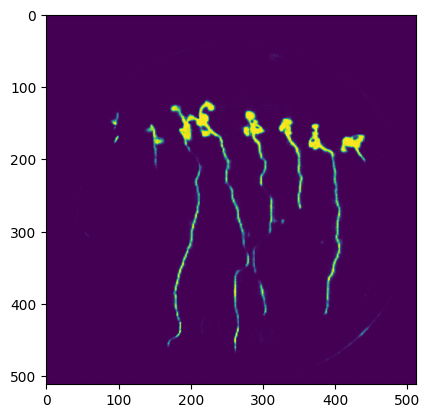

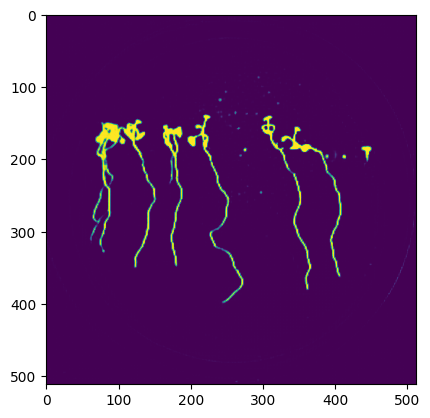

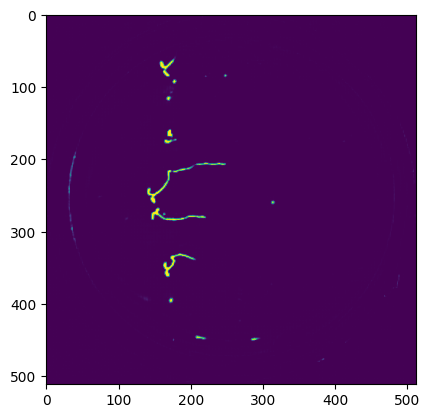

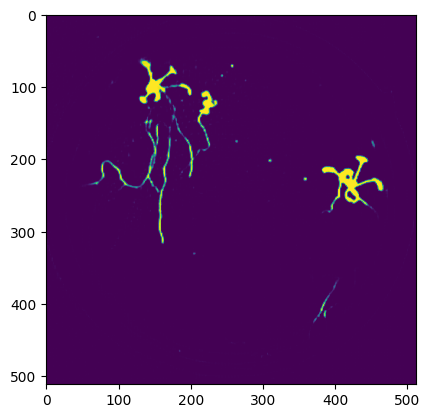

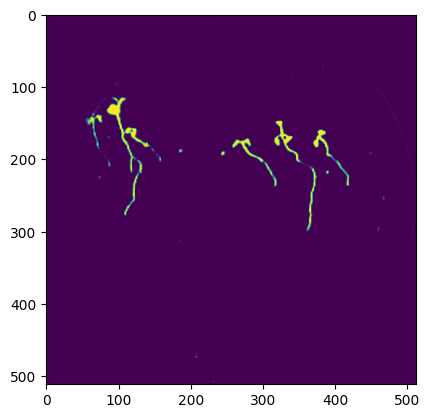

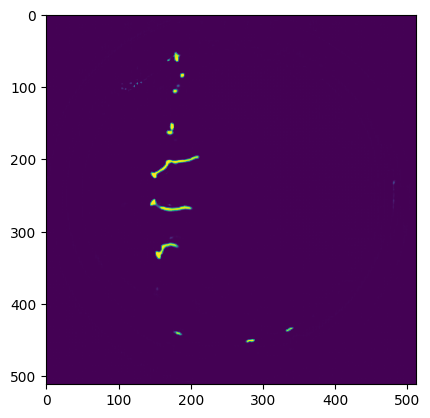

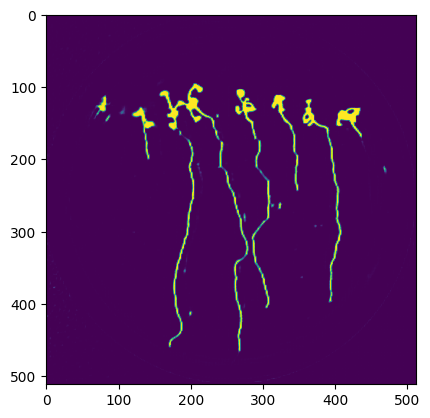

In [21]:
for i in outputs:
    i.reshape(1, height, height)
    plt.imshow(i.cpu().permute(1,2,0).detach().numpy())
    plt.pause(1)